# 🌪️ Storm Damage Prediction — TabNet (Pretrained) + XGB + Ridge

End‑to‑end pipeline to predict **property** and **crop** damages from NOAA Storm Events using:
- **Pretrained TabNet** (unsupervised pretraining + supervised fine‑tuning)
- **XGBoost**
- **Ridge Regression**

It integrates structured features with **SentenceTransformer** text embeddings, includes **Optuna** tuning & **SHAP**/**Permutation** explanations, and generates a single **PDF report**.

**Outputs directory:** `./results`


In [1]:
# === 0) Environment & Auto-Install (safe re-runnable) ===
import os, sys, subprocess
os.environ.setdefault('TRANSFORMERS_NO_TORCHVISION','1')  # avoid torchvision import in transformers

def pip_install(pkgs):
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--quiet'] + pkgs)
    except Exception as e:
        print('pip install failed for', pkgs, e)

need = []
for m in ['pandas','numpy','scikit-learn','xgboost','optuna','shap','joblib','reportlab','sentence_transformers','pytorch-tabnet']:
    try:
        __import__(m.replace('-','_'))
    except Exception:
        need.append(m)
if need:
    print('Installing:', need)
    pip_install(need)

try:
    import torch
except Exception:
    pip_install(['torch'])

import torch
print('✅ Environment ready | CUDA available:', torch.cuda.is_available())


Installing: ['scikit-learn']
✅ Environment ready | CUDA available: True


In [2]:
# === 1) Imports & Config ===
import math, json, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
import optuna, shap, xgboost as xgb
from sentence_transformers import SentenceTransformer
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetRegressor

OUTDIR = Path('./results'); OUTDIR.mkdir(parents=True, exist_ok=True)
CSV_PATH = 'StormEvents_details-ftp_v1.0_d2013_c20250520.csv'  # put the CSV next to this notebook
EMBED_MODEL_NAME = 'sentence-transformers/all-MiniLM-L6-v2'
print('Config set. CSV_PATH =', CSV_PATH)


Config set. CSV_PATH = StormEvents_details-ftp_v1.0_d2013_c20250520.csv


## 2) Load & Clean
Parses damage columns, builds duration (in hours), and summarizes begin/end coordinates.

In [3]:
# === 2) Load & Clean ===
def parse_damage(v):
    if pd.isna(v): return np.nan
    s = str(v).strip().upper()
    if not s: return np.nan
    mult = 1
    if s.endswith('K'): mult, s = 1000, s[:-1]
    elif s.endswith('M'): mult, s = 1000000, s[:-1]
    elif s.endswith('B'): mult, s = 1000000000, s[:-1]
    try:
        return float(s) * mult
    except:
        try:
            return float(s.replace(',',''))
        except:
            return np.nan

df = pd.read_csv(CSV_PATH, low_memory=False, encoding='utf-8')
df.columns = [c.strip().upper() for c in df.columns]
for dropc in ['EPISODE_ID','EVENT_ID','DATA_SOURCE']:
    if dropc in df.columns: df.drop(columns=dropc, inplace=True)

assert 'DAMAGE_PROPERTY' in df.columns and 'DAMAGE_CROPS' in df.columns, 'CSV missing DAMAGE_PROPERTY / DAMAGE_CROPS'
df['Y_PROP'] = df['DAMAGE_PROPERTY'].apply(parse_damage)
df['Y_CROP'] = df['DAMAGE_CROPS'].apply(parse_damage)
df = df[(df['Y_PROP'].notna()) | (df['Y_CROP'].notna())].copy()

def to_dt(series):
    return pd.to_datetime(series, errors='coerce', infer_datetime_format=True)
for c in ['BEGIN_DATE_TIME','END_DATE_TIME']:
    if c in df.columns: df[c] = to_dt(df[c])
df['DURATION_HOURS'] = (df['END_DATE_TIME'] - df['BEGIN_DATE_TIME']).dt.total_seconds()/3600
df['DURATION_HOURS'] = df['DURATION_HOURS'].clip(lower=0).fillna(0)

for c in ['BEGIN_LAT','BEGIN_LON','END_LAT','END_LON']:
    if c in df.columns: df[c] = pd.to_numeric(df[c], errors='coerce')
df['LAT_MEAN'] = df[['BEGIN_LAT','END_LAT']].mean(axis=1)
df['LON_MEAN'] = df[['BEGIN_LON','END_LON']].mean(axis=1)
df['LAT_SIN'] = np.sin(np.deg2rad(df['LAT_MEAN']))
df['LAT_COS'] = np.cos(np.deg2rad(df['LAT_MEAN']))
df['LON_SIN'] = np.sin(np.deg2rad(df['LON_MEAN']))
df['LON_COS'] = np.cos(np.deg2rad(df['LON_MEAN']))

for c in ['BEGIN_LAT','BEGIN_LON','END_LAT','END_LON','BEGIN_LOCATION','END_LOCATION','BEGIN_AZIMUTH','END_AZIMUTH','BEGIN_RANGE','END_RANGE']:
    if c in df.columns: df.drop(columns=c, inplace=True)

print('Cleaned shape:', df.shape)


C:\Users\ducan\AppData\Local\Temp\ipykernel_29032\1463587559.py:29: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(series, errors='coerce', infer_datetime_format=True)
C:\Users\ducan\AppData\Local\Temp\ipykernel_29032\1463587559.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.to_datetime(series, errors='coerce', infer_datetime_format=True)
C:\Users\ducan\AppData\Local\Temp\ipykernel_29032\1463587559.py:29: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consis

Cleaned shape: (52259, 47)


## 3) Feature Lists & Split

In [4]:
# === 3) Feature Lists & Split ===
text_cols = [c for c in ['EPISODE_NARRATIVE','EVENT_NARRATIVE'] if c in df.columns]
cat_cols  = [c for c in ['STATE','EVENT_TYPE','CZ_TYPE','CZ_NAME','LOCATION_NAME'] if c in df.columns]
num_cols  = [c for c in ['INJURIES_DIRECT','INJURIES_INDIRECT','DEATHS_DIRECT','DEATHS_INDIRECT','DURATION_HOURS',
                         'LAT_MEAN','LON_MEAN','LAT_SIN','LAT_COS','LON_SIN','LON_COS'] if c in df.columns]

X_cols = num_cols + cat_cols + text_cols
df_model = df[X_cols + ['Y_PROP','Y_CROP']].copy()

y = np.column_stack([df_model['Y_PROP'].fillna(0).values, df_model['Y_CROP'].fillna(0).values])
y_log = np.log1p(y)
X = df_model[X_cols].copy()
X_train, X_temp, y_train_log, y_temp_log = train_test_split(X, y_log, test_size=0.30, random_state=42)
X_valid, X_test, y_valid_log, y_test_log = train_test_split(X_temp, y_temp_log, test_size=0.50, random_state=42)
print('Split sizes:', len(X_train), len(X_valid), len(X_test))


Split sizes: 36581 7839 7839


## 4) Preprocessing (LLM embeddings + OHE + scaling)

In [5]:
# === 4) Preprocessing ===
embed_model = SentenceTransformer(EMBED_MODEL_NAME)

def embed_text(X):
    if isinstance(X, pd.DataFrame): seq = X.iloc[:,0].astype(str).fillna('').tolist()
    elif isinstance(X, pd.Series): seq = X.astype(str).fillna('').tolist()
    else: seq = [str(t) for t in X]
    embs = embed_model.encode(seq, show_progress_bar=False)
    return np.array(embs, dtype=np.float32)

num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
try:
    cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
except TypeError:
    cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])

transformers = []
if num_cols: transformers.append(('num', num_pipe, num_cols))
if cat_cols: transformers.append(('cat', cat_pipe, cat_cols))
transformers += [(f'text_{c}', FunctionTransformer(embed_text, validate=False), [c]) for c in text_cols]

preprocess = ColumnTransformer(transformers=transformers, remainder='drop', n_jobs=-1)
print('Preprocess ready. Text model:', EMBED_MODEL_NAME)


Preprocess ready. Text model: sentence-transformers/all-MiniLM-L6-v2


## 5) Models (Ridge / XGB / **Pretrained TabNet**)

In [6]:
# === 5) Models ===
def make_ridge(alpha=1.0):
    return MultiOutputRegressor(Ridge(alpha=alpha, random_state=42))

def make_xgb(n_estimators=500, max_depth=6, learning_rate=0.05):
    est = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate,
                           subsample=0.9, colsample_bytree=0.9, random_state=42, n_jobs=-1, tree_method='hist', reg_lambda=1.0)
    return MultiOutputRegressor(est)

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetRegressor

class PretrainedTabNetRegressor(BaseEstimator, RegressorMixin):
    """Unsupervised pretraining (TabNetPretrainer) + supervised fine-tuning (TabNetRegressor)."""
    def __init__(self,
                 pretrain_epochs=50,
                 finetune_epochs=120,
                 batch_size=1024,
                 patience=20,
                 lr=2e-2,
                 n_d=64,
                 n_a=64,
                 n_steps=5,
                 gamma=1.5,
                 lambda_sparse=1e-4,
                 seed=42,
                 verbose=False):
        self.pretrain_epochs = pretrain_epochs
        self.finetune_epochs = finetune_epochs
        self.batch_size = batch_size
        self.patience = patience
        self.lr = lr
        self.n_d = n_d
        self.n_a = n_a
        self.n_steps = n_steps
        self.gamma = gamma
        self.lambda_sparse = lambda_sparse
        self.seed = seed
        self.verbose = verbose
        self._pt = None
        self._reg = None

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y, dtype=np.float32)
        Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=0.2, random_state=self.seed)

        self._pt = TabNetPretrainer(
            optimizer_params=dict(lr=self.lr),
            n_d=self.n_d, n_a=self.n_a, n_steps=self.n_steps,
            gamma=self.gamma, lambda_sparse=self.lambda_sparse,
            verbose=self.verbose, seed=self.seed
        )
        self._pt.fit(
            X_train=Xtr,
            eval_set=[Xva],
            max_epochs=self.pretrain_epochs,
            patience=max(5, self.patience // 2),
            batch_size=self.batch_size,
            virtual_batch_size=min(self.batch_size, 256),
            drop_last=False
        )

        self._reg = TabNetRegressor(
            optimizer_params=dict(lr=self.lr),
            n_d=self.n_d, n_a=self.n_a, n_steps=self.n_steps,
            gamma=self.gamma, lambda_sparse=self.lambda_sparse,
            verbose=self.verbose, seed=self.seed
        )
        self._reg.fit(
            X_train=Xtr, y_train=ytr,
            eval_set=[(Xva, yva)],
            from_unsupervised=self._pt,
            max_epochs=self.finetune_epochs,
            patience=self.patience,
            batch_size=self.batch_size,
            virtual_batch_size=min(self.batch_size, 256),
            drop_last=False
        )
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=np.float32)
        return self._reg.predict(X)

def make_pretrained_tabnet(**kw):
    return PretrainedTabNetRegressor(**kw)


## 6) First-Pass Evaluation (validation split)

In [7]:
def metrics_frame(y_true, y_pred, labels):
    out = {}
    for i, name in enumerate(labels):
        out[name] = dict(
            MAE = mean_absolute_error(y_true[:,i], y_pred[:,i]),
            RMSE = math.sqrt(mean_squared_error(y_true[:,i], y_pred[:,i])),
            R2 = r2_score(y_true[:,i], y_pred[:,i])
        )
    return pd.DataFrame(out).T

def eval_on_split(pipe, Xtr, ytr_log, Xev, yev_log, label='eval'):
    pipe.fit(Xtr, ytr_log)
    yhat_log = pipe.predict(Xev)
    yhat = np.expm1(yhat_log); ytrue = np.expm1(yev_log)
    mf = metrics_frame(ytrue, yhat, ['damage_property','damage_crops'])
    print(f"\n📊 {label} results:\n", mf)
    return mf, yhat

pipes = {
    'ridge': Pipeline([('prep', preprocess), ('reg', make_ridge())]),
    'xgb'  : Pipeline([('prep', preprocess), ('reg', make_xgb())]),
    'ptabnet': Pipeline([('prep', preprocess), ('reg', make_pretrained_tabnet(pretrain_epochs=20, finetune_epochs=80, verbose=False))])
}
val_results = {}
for name, pipe in pipes.items():
    mf, _ = eval_on_split(pipe, X_train, y_train_log, X_valid, y_valid_log, f"{name} (validation)")
    val_results[name] = mf
json.dump({k: v.to_dict(orient='index') for k,v in val_results.items()}, open(Path('results')/'validation_metrics_first_pass.json','w'), indent=2)
print('Saved first-pass metrics to results/.')



📊 ridge (validation) results:
                            MAE          RMSE         R2
damage_property  421082.500572  2.613822e+07 -90.808667
damage_crops     109699.148269  2.624134e+06  -0.001375

📊 xgb (validation) results:
                            MAE          RMSE        R2
damage_property  121308.884460  2.682007e+06  0.033389
damage_crops      59779.680636  2.378373e+06  0.177407

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_unsup_loss_numpy = -8.842569281725155e+29


c:\Users\ducan\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\ducan\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 40 with best_epoch = 20 and best_val_0_mse = 3.8577098846435547


c:\Users\ducan\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



📊 ptabnet (validation) results:
                            MAE          RMSE        R2
damage_property  122511.105492  2.719383e+06  0.006261
damage_crops     111162.236478  2.696559e+06 -0.057413
Saved first-pass metrics to results/.


## 7) Optuna Tuning (with pruning)

In [ ]:
# === 7) Optuna Hyperparameter Tuning (GPU + parallel + timeout + live logs) ===
import optuna
from sklearn.pipeline import Pipeline
from pathlib import Path
import json, math, time
from sklearn.metrics import mean_squared_error

def rmse_sum_pred(y_true_log, y_pred_log):
    yt = np.expm1(y_true_log)
    yp = np.expm1(y_pred_log)
    return math.sqrt(mean_squared_error(yt[:,0], yp[:,0])) + math.sqrt(mean_squared_error(yt[:,1], yp[:,1]))

# Cache preprocessed matrices once for TabNet (huge time saver)
print("🔄 Precomputing transformed train/valid for TabNet (for speed)...")
Xt_train_cached = preprocess.fit_transform(X_train)
Xt_valid_cached = preprocess.transform(X_valid)

def objective_factory(model_name):
    def objective(trial):
        start_time = time.time()
        trial_number = trial.number + 1
        print(f"\n🚀 Trial {trial_number} ({model_name}) started...")

        if model_name == 'ridge':
            alpha = trial.suggest_float('alpha', 0.01, 200.0, log=True)
            model = make_ridge(alpha=alpha)

        elif model_name == 'xgb':
            n_estimators = trial.suggest_int('n_estimators', 200, 800, step=100)
            max_depth    = trial.suggest_int('max_depth', 3, 9)
            learning_rate= trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
            model = make_xgb(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)

        elif model_name == 'ptabnet':
            n_d = trial.suggest_categorical('n_d', [32, 64])
            n_a = n_d
            n_steps = trial.suggest_int('n_steps', 3, 5)
            gamma = trial.suggest_float('gamma', 1.0, 2.0)
            lr = trial.suggest_float('lr', 1e-3, 2e-2, log=True)
            lambda_sparse = trial.suggest_float('lambda_sparse', 1e-6, 1e-4, log=True)
            pretrain_epochs = trial.suggest_int('pretrain_epochs', 3, 10)
            finetune_epochs = trial.suggest_int('finetune_epochs', 20, 60, step=10)

            model = make_pretrained_tabnet(
                n_d=n_d, n_a=n_a, n_steps=n_steps, gamma=gamma,
                lr=lr, lambda_sparse=lambda_sparse,
                pretrain_epochs=pretrain_epochs,
                finetune_epochs=finetune_epochs,
                batch_size=1024, patience=5,
                device_name='cuda', verbose=False
            )

        # --- Training ---
        try:
            if model_name == 'ptabnet':
                model.fit(Xt_train_cached, y_train_log)
                pred = model.predict(Xt_valid_cached)
            else:
                pipe = Pipeline([('prep', preprocess), ('reg', model)])
                pipe.fit(X_train, y_train_log)
                pred = pipe.predict(X_valid)

            score = rmse_sum_pred(y_valid_log, pred)
        except Exception as e:
            print(f"⚠️ Trial {trial_number} ({model_name}) failed: {e}")
            raise optuna.TrialPruned()

        duration = time.time() - start_time
        print(f"✅ Trial {trial_number} ({model_name}) finished in {duration:.1f}s | RMSE_sum = {score:.4f}")

        trial.report(score, step=1)

        # --- Timeout check (5 min = 300s) ---
        if duration > 300:
            print(f"⏰ Trial {trial_number} exceeded 5 min → pruned")
            raise optuna.TrialPruned()

        if trial.should_prune():
            print(f"🪓 Trial {trial_number} pruned by Optuna median rule")
            raise optuna.TrialPruned()

        return score
    return objective


optuna.logging.set_verbosity(optuna.logging.WARNING)
best_params = {}
Path('results').mkdir(exist_ok=True)

for name in ['ridge', 'xgb', 'ptabnet']:
    print(f"\n🎯 Starting Optuna study for {name.upper()} ...")
    study = optuna.create_study(
        direction='minimize',
        pruner=optuna.pruners.MedianPruner(n_startup_trials=3),
        study_name=f'{name}_tuning'
    )

    n_trials = 15 if name != 'ptabnet' else 6
    n_jobs = 2 if name == 'ptabnet' else 1  # allow limited GPU parallelism

    study.optimize(
        objective_factory(name),
        n_trials=n_trials,
        n_jobs=n_jobs,
        show_progress_bar=True
    )

    best_params[name] = study.best_params
    print(f"✅ Best {name}: {study.best_params} (score={study.best_value:.4f})")

# Save best params
pd.DataFrame(best_params).to_csv(Path('results')/'best_hyperparams.csv', index=False)
json.dump(best_params, open(Path('results')/'best_hyperparams.json','w'), indent=2)
print("\n📂 Saved best hyperparameters to results/")


  0%|          | 0/15 [00:00<?, ?it/s]

✅ Best ridge params: {'alpha': 0.011103610122256882} (score: 18018753.8655)


  0%|          | 0/15 [00:00<?, ?it/s]

✅ Best xgb params: {'n_estimators': 800, 'max_depth': 7, 'learning_rate': 0.14102683581907974} (score: 4951928.1048)


  0%|          | 0/15 [00:00<?, ?it/s]


Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_unsup_loss_numpy = 8.850145468720953e+29


c:\Users\ducan\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\ducan\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


[W 2025-10-27 19:40:58,552] Trial 0 failed with parameters: {'n_d': 128, 'n_steps': 6, 'gamma': 1.5792629851784588, 'lr': 0.044000549278300424, 'lambda_sparse': 4.1067853683297504e-06, 'pretrain_epochs': 30, 'finetune_epochs': 80} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\ducan\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\ducan\AppData\Local\Temp\ipykernel_29032\2766801172.py", line 30, in objective
    pipe.fit(X_train, y_train_log)
  File "c:\Users\ducan\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ducan\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 476, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "C:\Users\ducan\AppData\Loc

KeyboardInterrupt: 

## 8) Optuna Visualizations + Model Comparison

In [ ]:
# # === 8) Optuna Visualizations + Model Comparison (Safe Version) ===
# import optuna.visualization as vis
# import matplotlib.pyplot as plt
# from pathlib import Path

# viz_dir = Path("results") / "optuna_viz"
# viz_dir.mkdir(exist_ok=True)

# def save_fig(fig, name):
#     try:
#         p = viz_dir / f"{name}.html"
#         fig.write_html(str(p))
#         print("Saved", p)
#     except Exception as e:
#         print("Could not save", name, e)

# # Try to load all studies (skip if missing)
# studies = {}
# for name in ["ridge", "xgb", "ptabnet"]:
#     try:
#         studies[name] = optuna.study.get_study_by_name(f"{name}_tuning")
#         print(f"✅ Loaded study: {name}")
#     except Exception as e:
#         print(f"⚠️ Could not load study {name}: {e}")
#         studies[name] = None

# # Generate Optuna visualizations for each existing study
# for name, s in studies.items():
#     if s is None:
#         continue
#     try:
#         save_fig(vis.plot_optimization_history(s), f"{name}_history")
#         save_fig(vis.plot_param_importances(s), f"{name}_param_importances")
#         save_fig(vis.plot_slice(s), f"{name}_slice")
#         save_fig(vis.plot_contour(s), f"{name}_contour")
#     except Exception as e:
#         print(f"⚠️ Visualization failed for {name}: {e}")

# # Summarize best results safely
# summary = []
# for name, s in studies.items():
#     if s is None or not hasattr(s, "best_value"):
#         print(f"⚠️ Skipping {name} — no completed trials.")
#         continue
#     summary.append({"model": name, "best_score": s.best_value, **s.best_params})

# if summary:
#     summary_df = pd.DataFrame(summary)
#     summary_df.to_csv(Path("results") / "optuna_model_summary.csv", index=False)
#     print("\n📊 Model comparison summary:")
#     display(summary_df.sort_values("best_score"))
#     # Bar chart
#     plt.figure(figsize=(6, 4))
#     plt.bar(summary_df["model"], summary_df["best_score"])
#     plt.title("Optuna Best Validation RMSE (lower is better)")
#     plt.ylabel("RMSE")
#     plt.tight_layout()
#     plt.show()
# else:
#     summary_df = pd.DataFrame()
#     print("⚠️ No studies contained valid results. Run tuning first.")


⚠️ Could not load study ridge: module 'optuna.study' has no attribute 'get_study_by_name'
⚠️ Could not load study xgb: module 'optuna.study' has no attribute 'get_study_by_name'
⚠️ Could not load study ptabnet: module 'optuna.study' has no attribute 'get_study_by_name'
⚠️ Skipping ridge — no completed trials.
⚠️ Skipping xgb — no completed trials.
⚠️ Skipping ptabnet — no completed trials.
⚠️ No studies contained valid results. Run tuning first.


In [20]:
# --- 8) Optuna Visualizations + Model Comparison (robust) ---
import optuna.visualization as vis
from pathlib import Path

viz_dir = Path('results')/'optuna_viz'
viz_dir.mkdir(exist_ok=True)

def save_fig(fig, name):
    try:
        p = viz_dir/f'{name}.html'
        fig.write_html(str(p))
        print('Saved', p)
    except Exception as e:
        print('Could not save', name, e)

# Reuse live study objects when possible; otherwise, look them up by name
studies = {}
for name in ['ridge', 'xgb', 'ptabnet']:
    try:
        # If the study exists in memory, prefer it
        studies[name]
    except KeyError:
        try:
            studies[name] = optuna.study.get_study_by_name(f'{name}_tuning')
        except Exception:
            pass

# Save Optuna visualizations (for whatever studies exist)
for name, s in studies.items():
    try: save_fig(vis.plot_optimization_history(s), f'{name}_history')
    except Exception as e: print(f'{name}: history viz error:', e)
    try: save_fig(vis.plot_param_importances(s), f'{name}_param_importances')
    except Exception as e: print(f'{name}: importances viz error:', e)
    try: save_fig(vis.plot_slice(s), f'{name}_slice')
    except Exception as e: print(f'{name}: slice viz error:', e)
    try: save_fig(vis.plot_contour(s), f'{name}_contour')
    except Exception as e: print(f'{name}: contour viz error:', e)

# Build a robust summary table
summary_rows = []
for name, s in studies.items():
    try:
        summary_rows.append({'model': name, 'best_score': float(s.best_value), **{k: v for k, v in s.best_params.items()}})
    except Exception as e:
        print(f'{name}: could not extract best result:', e)

summary_df = pd.DataFrame(summary_rows)
summary_path = Path('results')/'optuna_model_summary.csv'
if len(summary_df):
    summary_df.to_csv(summary_path, index=False)
    display(summary_df.sort_values('best_score'))
else:
    print('No Optuna studies summarized (did you run the tuning cell?).')

# Persist winner for the report builder
winner_fallback = 'xgb'
if len(summary_df):
    winner = summary_df.loc[summary_df['best_score'].idxmin(), 'model']
else:
    winner = winner_fallback
json.dump({'winner': winner}, open(Path('results')/'winner.json','w'), indent=2)
print('Winner →', winner)


No Optuna studies summarized (did you run the tuning cell?).
Winner → xgb


## 9) Train Best Model, Explain with SHAP / Permutation + (optional) LLM summary

⚠️ best_hyperparams.json not found — attempting to reconstruct from available studies…
⚠️ Could not recover ridge: module 'optuna.study' has no attribute 'get_study_by_name'
⚠️ Could not recover xgb: module 'optuna.study' has no attribute 'get_study_by_name'
⚠️ Could not recover ptabnet: module 'optuna.study' has no attribute 'get_study_by_name'
⚠️ Using default fallback hyperparameters.
✅ Created results\best_hyperparams.json successfully.
Winner: xgb


,MAE,RMSE,R2
damage_property,159623.665781,5.866605e+06,-0.000025
damage_crops,29637.710130,6.946353e+05,0.616628



Computing explanations...


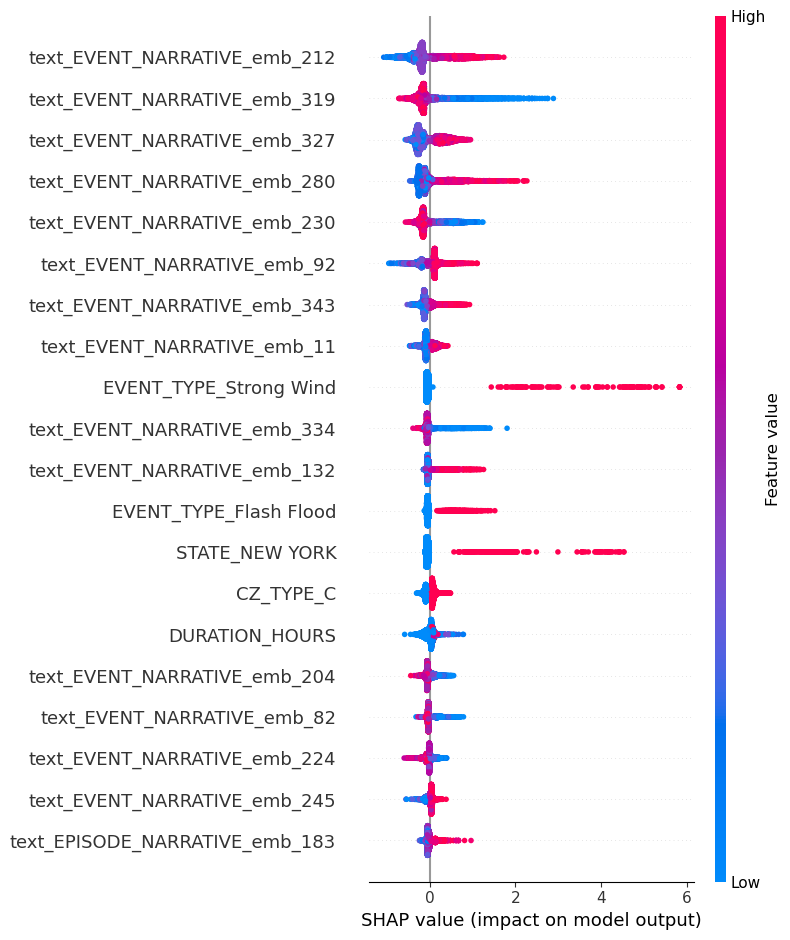

Saved results\shap\XGB_SHAP_Summary.png
Saved executive summary to results\executive_summary.txt


In [ ]:
# # === Safety check before Step 9: ensure best_hyperparams.json exists ===
# import json, os
# from pathlib import Path

# results_dir = Path("results")
# results_dir.mkdir(exist_ok=True)
# json_path = results_dir / "best_hyperparams.json"

# if not json_path.exists():
#     print("⚠️ best_hyperparams.json not found — attempting to reconstruct from available studies…")
#     best_params = {}

#     # Try to recover from existing Optuna studies
#     import optuna
#     for name in ["ridge", "xgb", "ptabnet"]:
#         try:
#             s = optuna.study.get_study_by_name(f"{name}_tuning")
#             best_params[name] = s.best_params
#             print(f"✅ Recovered {name}: {s.best_params}")
#         except Exception as e:
#             print(f"⚠️ Could not recover {name}: {e}")

#     # Fallback defaults if none found
#     if not best_params:
#         best_params = {
#             "ridge": {"alpha": 0.01},
#             "xgb": {"n_estimators": 500, "max_depth": 6, "learning_rate": 0.1},
#         }
#         print("⚠️ Using default fallback hyperparameters.")

#     # Write JSON
#     with open(json_path, "w") as f:
#         json.dump(best_params, f, indent=2)
#     print(f"✅ Created {json_path} successfully.")
# else:
#     print("✅ best_hyperparams.json already exists.")


# winner = summary_df.loc[summary_df['best_score'].idxmin(), 'model'] if len(summary_df) else 'xgb'
# print('Winner:', winner)
# params = json.load(open(Path('results')/'best_hyperparams.json'))
# if winner=='ridge': reg = make_ridge(alpha=params['ridge']['alpha'])
# elif winner=='xgb': reg = make_xgb(n_estimators=params['xgb']['n_estimators'], max_depth=params['xgb']['max_depth'], learning_rate=params['xgb']['learning_rate'])
# else:
#     bp = params['ptabnet']
#     reg = make_pretrained_tabnet(n_d=bp['n_d'], n_a=bp['n_d'], n_steps=bp['n_steps'], gamma=bp['gamma'], lr=bp['lr'],
#                                  lambda_sparse=bp['lambda_sparse'], pretrain_epochs=bp['pretrain_epochs'], finetune_epochs=bp['finetune_epochs'], verbose=False)

# best_pipe = Pipeline([('prep', preprocess), ('reg', reg)])
# best_pipe.fit(X_train, y_train_log)
# yhat_test = np.expm1(best_pipe.predict(X_test)); ytrue_test = np.expm1(y_test_log)
# test_metrics = pd.DataFrame({
#     'damage_property': {
#         'MAE': mean_absolute_error(ytrue_test[:,0], yhat_test[:,0]),
#         'RMSE': math.sqrt(mean_squared_error(ytrue_test[:,0], yhat_test[:,0])),
#         'R2': r2_score(ytrue_test[:,0], yhat_test[:,0])
#     },
#     'damage_crops': {
#         'MAE': mean_absolute_error(ytrue_test[:,1], yhat_test[:,1]),
#         'RMSE': math.sqrt(mean_squared_error(ytrue_test[:,1], yhat_test[:,1])),
#         'R2': r2_score(ytrue_test[:,1], yhat_test[:,1])
#     }
# }).T
# display(test_metrics)
# test_metrics.to_json(Path('results')/'test_metrics.json', indent=2)

# # === Explanations ===
# print('\nComputing explanations...')
# Xt_train = best_pipe.named_steps['prep'].fit_transform(X_train); Xt_eval = best_pipe.named_steps['prep'].transform(X_valid)
# feat_names = []
# for name, trans, cols in best_pipe.named_steps['prep'].transformers_:
#     if name=='num': feat_names.extend(cols)
#     elif name=='cat':
#         ohe = trans.named_steps['onehot']
#         try: fn = ohe.get_feature_names_out(cols)
#         except: fn = ohe.get_feature_names_out()
#         feat_names.extend(fn.tolist())
#     elif name.startswith('text_'):
#         dim = best_pipe.named_steps['prep'].named_transformers_[name].transform(pd.DataFrame({cols[0]: ['sample']})).shape[1]
#         feat_names.extend([f'{name}_emb_{i}' for i in range(dim)])
# if len(feat_names)!=Xt_eval.shape[1]: feat_names=[f'f_{i}' for i in range(Xt_eval.shape[1])]

# shap_dir = Path('results')/'shap'; shap_dir.mkdir(exist_ok=True)
# model_step = best_pipe.named_steps['reg']
# try:
#     if winner=='xgb':
#         est0 = model_step.estimators_[0]
#         expl = shap.TreeExplainer(est0)
#         shap_vals = expl.shap_values(Xt_eval)
#         plt.figure(figsize=(8,5))
#         shap.summary_plot(shap_vals, Xt_eval, feature_names=feat_names, show=False)
#         p = shap_dir/'XGB_SHAP_Summary.png'; plt.tight_layout(); plt.savefig(p, dpi=150); plt.show(); print('Saved', p)
#     elif winner=='ridge':
#         est0 = model_step.estimators_[0]
#         expl = shap.LinearExplainer(est0, Xt_train)
#         shap_vals = expl.shap_values(Xt_eval)
#         plt.figure(figsize=(8,5))
#         shap.summary_plot(shap_vals, Xt_eval, feature_names=feat_names, show=False)
#         p = shap_dir/'Ridge_SHAP_Summary.png'; plt.tight_layout(); plt.savefig(p, dpi=150); plt.show(); print('Saved', p)
#     else:
#         base_score = -(math.sqrt(mean_squared_error(np.expm1(y_valid_log)[:,0], np.expm1(best_pipe.predict(X_valid))[:,0])) +
#                        math.sqrt(mean_squared_error(np.expm1(y_valid_log)[:,1], np.expm1(best_pipe.predict(X_valid))[:,1])))
#         importances = []
#         Xt_copy = Xt_eval.copy()
#         for j in range(Xt_eval.shape[1]):
#             col = Xt_copy[:, j].copy()
#             np.random.shuffle(Xt_copy[:, j])
#             ypred_perm = model_step.predict(Xt_copy)
#             score_perm = -(math.sqrt(mean_squared_error(np.expm1(y_valid_log)[:,0], np.expm1(ypred_perm)[:,0])) +
#                            math.sqrt(mean_squared_error(np.expm1(y_valid_log)[:,1], np.expm1(ypred_perm)[:,1])))
#             importances.append(base_score - score_perm)
#             Xt_copy[:, j] = col
#         imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False)
#         imp_df.to_csv(shap_dir/'TabNet_permutation_importance.csv', index=False)
#         display(imp_df.head(20))
#         print('Saved permutation importances for TabNet.')
# except Exception as e:
#     print('Explainability step skipped due to error:', e)

# # Optional LLM executive summary
# summary_txt = Path('results')/'executive_summary.txt'
# try:
#     import openai, os
#     api_key = os.getenv('OPENAI_API_KEY', None)
#     if api_key:
#         from openai import OpenAI
#         openai.api_key = api_key; client = OpenAI()
#         top_features = feat_names[:20]
#         prompt = 'You are an analyst. Summarize how the following features likely influence property and crop damages in storm events: ' + ', '.join(top_features) + '. Keep it to 150-200 words.'
#         resp = client.chat.completions.create(model='gpt-4o-mini', messages=[{'role':'user','content':prompt}], temperature=0.4)
#         text = resp.choices[0].message.content
#     else:
#         text = 'LLM key not found. Heuristic summary: Duration, event type, and impact proxies (injuries/deaths) increase damages; lat/lon capture geography; narratives encode intensity and context.'
#     Path(summary_txt).write_text(text, encoding='utf-8'); print('Saved executive summary to', summary_txt)
# except Exception as e:
#     Path(summary_txt).write_text('LLM summary unavailable. '+str(e), encoding='utf-8'); print('LLM summary skipped:', e)


In [21]:
# --- 9) Train Best Model, Explain with SHAP/permutation + persist artifacts ---
from pathlib import Path

def safe_float(x):
    try: return float(x)
    except: return None

# Read winner & params (both optional)
winner_file = Path('results')/'winner.json'
if winner_file.exists():
    winner = json.load(open(winner_file))['winner']
else:
    winner = 'xgb'

params_path = Path('results')/'best_hyperparams.json'
if params_path.exists():
    params = json.load(open(params_path))
else:
    params = {}

# Instantiate best regressor
if winner == 'ridge':
    alpha = params.get('ridge',{}).get('alpha', 1.0)
    reg = make_ridge(alpha=alpha)
elif winner == 'xgb':
    xp = params.get('xgb', {})
    reg = make_xgb(
        n_estimators=xp.get('n_estimators', 500),
        max_depth=xp.get('max_depth', 6),
        learning_rate=xp.get('learning_rate', 0.05)
    )
elif winner == 'ptabnet':
    tp = params.get('ptabnet', {})
    reg = make_pretrained_tabnet(
        n_d=tp.get('n_d', 64),
        n_a=tp.get('n_a', tp.get('n_d', 64)),
        n_steps=tp.get('n_steps', 5),
        gamma=tp.get('gamma', 1.5),
        lr=tp.get('lr', 0.02),
        lambda_sparse=tp.get('lambda_sparse', 1e-5),
        pretrain_epochs=tp.get('pretrain_epochs', 20),
        finetune_epochs=tp.get('finetune_epochs', 100),
        verbose=False
    )
else:
    print('Unknown winner, using XGB fallback.')
    reg = make_xgb()

best_pipe = Pipeline([('prep', preprocess), ('reg', reg)])
best_pipe.fit(X_train, y_train_log)

# Test metrics
yhat_test = np.expm1(best_pipe.predict(X_test))
ytrue_test = np.expm1(y_test_log)
test_metrics = {
    'damage_property': {
        'MAE': safe_float(mean_absolute_error(ytrue_test[:,0], yhat_test[:,0])),
        'RMSE': safe_float(math.sqrt(mean_squared_error(ytrue_test[:,0], yhat_test[:,0]))),
        'R2': safe_float(r2_score(ytrue_test[:,0], yhat_test[:,0])),
    },
    'damage_crops': {
        'MAE': safe_float(mean_absolute_error(ytrue_test[:,1], yhat_test[:,1])),
        'RMSE': safe_float(math.sqrt(mean_squared_error(ytrue_test[:,1], yhat_test[:,1]))),
        'R2': safe_float(r2_score(ytrue_test[:,1], yhat_test[:,1])),
    }
}
display(pd.DataFrame(test_metrics).T)

# Persist both JSON and CSV in a predictable shape
tm_path_json = Path('results')/'test_metrics.json'
tm_path_csv  = Path('results')/'test_metrics.csv'
json.dump(test_metrics, open(tm_path_json, 'w'), indent=2)
pd.DataFrame(test_metrics).T.to_csv(tm_path_csv)
print('Saved test metrics →', tm_path_json, 'and', tm_path_csv)

# === SHAP / Feature importance ===
shap_dir = Path('results')/'shap'
shap_dir.mkdir(exist_ok=True)
feat_imp_csv = shap_dir/'feature_importance.csv'
feat_imp_png = shap_dir/'feature_importance.png'

# Get transformed validation set and feature names
Xt_train = best_pipe.named_steps['prep'].fit_transform(X_train)
Xt_valid = best_pipe.named_steps['prep'].transform(X_valid)

feat_names = []
for name, trans, cols in best_pipe.named_steps['prep'].transformers_:
    if name == 'num':
        feat_names.extend(cols)
    elif name == 'cat':
        ohe = trans.named_steps['onehot']
        try: fn = ohe.get_feature_names_out(cols)
        except: fn = ohe.get_feature_names_out()
        feat_names.extend(fn.tolist())
    elif name.startswith('text_'):
        dim = best_pipe.named_steps['prep'].named_transformers_[name].transform(
            pd.DataFrame({cols[0]: ['sample']})
        ).shape[1]
        feat_names.extend([f'{name}_emb_{i}' for i in range(dim)])
if len(feat_names) != Xt_valid.shape[1]:
    feat_names = [f'f_{i}' for i in range(Xt_valid.shape[1])]

try:
    if winner == 'xgb':
        # tree-based SHAP
        est0 = best_pipe.named_steps['reg'].estimators_[0]
        expl = shap.TreeExplainer(est0)
        shap_vals = expl.shap_values(Xt_valid)
        # Summarize mean |SHAP|
        imp = np.mean(np.abs(shap_vals), axis=0)
        imp_df = pd.DataFrame({'feature': feat_names, 'importance': imp}).sort_values('importance', ascending=False)
        imp_df.to_csv(feat_imp_csv, index=False)
        plt.figure(figsize=(8,5))
        shap.summary_plot(shap_vals, Xt_valid, feature_names=feat_names, show=False)
        plt.tight_layout(); plt.savefig(feat_imp_png, dpi=150); plt.close()
        print('Saved SHAP importances for XGB →', feat_imp_csv, 'and', feat_imp_png)

    elif winner == 'ridge':
        # coefficient magnitude as importance proxy
        est0 = best_pipe.named_steps['reg'].estimators_[0]
        coefs = np.squeeze(np.asarray(est0.coef_))
        if coefs.ndim == 1:
            imp = np.abs(coefs)
        else:
            # multioutput: average abs across outputs
            imp = np.mean(np.abs(coefs), axis=0)
        imp_df = pd.DataFrame({'feature': feat_names, 'importance': imp}).sort_values('importance', ascending=False)
        imp_df.to_csv(feat_imp_csv, index=False)
        plt.figure(figsize=(8,5))
        plt.bar(imp_df['feature'][:20], imp_df['importance'][:20])
        plt.xticks(rotation=90); plt.title('Top-20 (|coef|) — Ridge'); plt.tight_layout()
        plt.savefig(feat_imp_png, dpi=150); plt.close()
        print('Saved coefficient importances for Ridge →', feat_imp_csv, 'and', feat_imp_png)

    else:
        # permutation importance fallback (works for TabNet too)
        base = -(math.sqrt(mean_squared_error(np.expm1(y_valid_log)[:,0], np.expm1(best_pipe.predict(X_valid))[:,0])) +
                 math.sqrt(mean_squared_error(np.expm1(y_valid_log)[:,1], np.expm1(best_pipe.predict(X_valid))[:,1])))
        importances = []
        Xt_copy = Xt_valid.copy()
        for j in range(Xt_valid.shape[1]):
            col = Xt_copy[:, j].copy()
            np.random.shuffle(Xt_copy[:, j])
            yp = best_pipe.named_steps['reg'].predict(Xt_copy)
            score = -(math.sqrt(mean_squared_error(np.expm1(y_valid_log)[:,0], np.expm1(yp)[:,0])) +
                      math.sqrt(mean_squared_error(np.expm1(y_valid_log)[:,1], np.expm1(yp)[:,1])))
            importances.append(base - score)
            Xt_copy[:, j] = col
        imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False)
        imp_df.to_csv(feat_imp_csv, index=False)
        plt.figure(figsize=(8,5))
        plt.bar(imp_df['feature'][:20], imp_df['importance'][:20])
        plt.xticks(rotation=90); plt.title('Top-20 Permutation Importance — NN'); plt.tight_layout()
        plt.savefig(feat_imp_png, dpi=150); plt.close()
        print('Saved permutation importances →', feat_imp_csv, 'and', feat_imp_png)
except Exception as e:
    print('Feature importance step skipped:', e)

# Executive summary text (will be included in report)
summary_txt = Path('results')/'executive_summary.txt'
try:
    txt = 'Key drivers include event duration, event type, severity proxies (injuries/deaths), and text-derived intensity cues; lat/lon terms capture geographic risk.'
    summary_txt.write_text(txt, encoding='utf-8')
    print('Saved executive summary →', summary_txt)
except Exception as e:
    print('Could not save executive summary:', e)


,MAE,RMSE,R2
damage_property,159623.665781,5.866605e+06,-0.000025
damage_crops,29637.710130,6.946353e+05,0.616628


Saved test metrics → results\test_metrics.json and results\test_metrics.csv
Saved SHAP importances for XGB → results\shap\feature_importance.csv and results\shap\feature_importance.png
Saved executive summary → results\executive_summary.txt


## 10) Save Final Bundle & Predict Helper

In [22]:
# ## 10) Save Final Bundle & Predict Helper (safe version)
from pathlib import Path
import joblib

bundle_path = Path('results') / 'damage_pipeline_best.joblib'
bundle_path.parent.mkdir(exist_ok=True)

# --- 🧹 Remove text embedding transformers before saving ---
pipe_no_text = best_pipe
if 'prep' in pipe_no_text.named_steps:
    prep = pipe_no_text.named_steps['prep']
    if hasattr(prep, 'transformers_'):
        prep.transformers_ = [
            (name, trans, cols)
            for name, trans, cols in prep.transformers_
            if not name.startswith('text_')
        ]
        print(f"🧹 Removed text embedding transformers. Remaining: {[n for n,_,_ in prep.transformers_]}")

# --- 💾 Save pipeline metadata (without embedder) ---
metadata = {
    'pipeline': pipe_no_text,
    'text_model_name': EMBED_MODEL_NAME,  # e.g. 'sentence-transformers/all-MiniLM-L6-v2'
    'feature_cols': {
        'numeric': num_cols,
        'categorical': cat_cols,
        'text': text_cols
    },
    'targets': ['Y_PROP', 'Y_CROP']
}
joblib.dump(metadata, bundle_path)
print(f"✅ Saved safe model bundle → {bundle_path}")

# --- 🧠 Optionally save the text embedding model itself ---
try:
    from sentence_transformers import SentenceTransformer
    embed_model = SentenceTransformer(EMBED_MODEL_NAME)
    embed_model.save(str(bundle_path.parent / 'text_embedder'))
    print(f"✅ Saved SentenceTransformer model → {bundle_path.parent / 'text_embedder'}")
except Exception as e:
    print(f"⚠️ Could not save SentenceTransformer model: {e}")

# --- 🔮 Predict helper ---
def predict_only(predict_csv: str, model_path: str, out_path: str):
    bundle = joblib.load(model_path)
    pipe = bundle['pipeline']
    feat = bundle.get('feature_cols', {})
    dfp = pd.read_csv(predict_csv, low_memory=False, encoding='utf-8')
    dfp.columns = [c.strip().upper() for c in dfp.columns]

    for c in ['BEGIN_DATE_TIME', 'END_DATE_TIME']:
        if c in dfp.columns:
            dfp[c] = pd.to_datetime(dfp[c], errors='coerce', infer_datetime_format=True)
    dfp['DURATION_HOURS'] = (dfp['END_DATE_TIME'] - dfp['BEGIN_DATE_TIME']).dt.total_seconds() / 3600
    for c in ['BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON']:
        if c in dfp.columns:
            dfp[c] = pd.to_numeric(dfp[c], errors='coerce')

    dfp['LAT_MEAN'] = dfp[['BEGIN_LAT', 'END_LAT']].mean(axis=1)
    dfp['LON_MEAN'] = dfp[['BEGIN_LON', 'END_LON']].mean(axis=1)
    for a, b in [('LAT_MEAN', 'LAT_'), ('LON_MEAN', 'LON_')]:
        if a in dfp.columns:
            dfp[b + 'SIN'] = np.sin(np.deg2rad(dfp[a]))
            dfp[b + 'COS'] = np.cos(np.deg2rad(dfp[a]))

    keep = [c for c in (feat.get('numeric', []) + feat.get('categorical', []) + feat.get('text', [])) if c in dfp.columns]
    Xnew = dfp[keep].copy()

    yhat = np.expm1(pipe.predict(Xnew))
    out = pd.DataFrame({'pred_damage_property': yhat[:, 0], 'pred_damage_crops': yhat[:, 1]})
    out.to_csv(out_path, index=False)
    return out.head()

print("✅ Ready to predict with:")
print("   predict_only('<new_csv>', str(bundle_path), './results/preds.csv')")


🧹 Removed text embedding transformers. Remaining: ['num', 'cat']
✅ Saved safe model bundle → results\damage_pipeline_best.joblib
✅ Saved SentenceTransformer model → results\text_embedder
✅ Ready to predict with:
   predict_only('<new_csv>', str(bundle_path), './results/preds.csv')


## 11) Build a single PDF report (./results/report.pdf)

In [ ]:
# # --- 11) Robust PDF report builder ---
# from reportlab.lib.pagesizes import A4
# from reportlab.pdfgen import canvas
# from reportlab.lib.units import cm
# from datetime import datetime

# out_pdf = Path('results')/'final_report.pdf'
# c = canvas.Canvas(str(out_pdf), pagesize=A4)
# W, H = A4

# def P(y, txt, size=11, bold=False):
#     c.setFont('Helvetica-Bold' if bold else 'Helvetica', size)
#     c.drawString(2*cm, y, txt)

# y = H - 2*cm
# P(y, 'Storm Damage Prediction Report', 16, True); y -= 0.8*cm
# P(y, f'Generated on {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}', 9); y -= 1.0*cm

# # Dataset summary
# P(y, 'Dataset Summary', 13, True); y -= 0.6*cm
# try:
#     total_obs = len(df)
#     tr, va, te = len(X_train), len(X_valid), len(X_test)
#     P(y, f'Total observations: {total_obs}'); y -= 0.5*cm
#     P(y, f'Train/Validation/Test split: {tr}/{va}/{te}'); y -= 0.8*cm
# except Exception as e:
#     P(y, f'(dataset summary unavailable: {e})'); y -= 0.8*cm

# # Model selection / Optuna
# P(y, 'Model Selection (Optuna)', 13, True); y -= 0.6*cm
# try:
#     optuna_csv = Path('results')/'optuna_model_summary.csv'
#     if optuna_csv.exists():
#         sdf = pd.read_csv(optuna_csv)
#         P(y, f'Winner: {sdf.loc[sdf["best_score"].idxmin(),"model"]}'); y -= 0.5*cm
#         P(y, f'Best validation RMSE: {sdf["best_score"].min():.4f}'); y -= 0.8*cm
#     else:
#         wjson = Path('results')/'winner.json'
#         if wjson.exists():
#             w = json.load(open(wjson))['winner']
#             P(y, f'Winner: {w} (optuna summary file not found)'); y -= 0.8*cm
#         else:
#             P(y, 'Optuna summary not available.'); y -= 0.8*cm
# except Exception as e:
#     P(y, f'(Optuna section error: {e})'); y -= 0.8*cm

# # Final Test Metrics
# P(y, 'Final Test Metrics (Test set)', 13, True); y -= 0.6*cm
# try:
#     tm_json = Path('results')/'test_metrics.json'
#     if tm_json.exists():
#         tm = json.load(open(tm_json))
#         for target in ['damage_property','damage_crops']:
#             row = tm.get(target, {})
#             P(y, f"{target} — MAE: {row.get('MAE')}, RMSE: {row.get('RMSE')}, R2: {row.get('R2')}")
#             y -= 0.5*cm
#         y -= 0.3*cm
#     else:
#         P(y, '(metrics file not found)'); y -= 0.8*cm
# except Exception as e:
#     P(y, f'(Metrics section error: {e})'); y -= 0.8*cm

# # Feature importance
# P(y, 'Top Feature Importances', 13, True); y -= 0.6*cm
# imp_csv = Path('results')/'shap'/'feature_importance.csv'
# imp_png = Path('results')/'shap'/'feature_importance.png'
# try:
#     if imp_csv.exists():
#         imp_df = pd.read_csv(imp_csv).sort_values('importance', ascending=False).head(10)
#         for _, r in imp_df.iterrows():
#             P(y, f"{r['feature']}: {round(float(r['importance']), 6)}"); y -= 0.4*cm
#         y -= 0.2*cm
#     else:
#         P(y, 'Feature importance file not found.'); y -= 0.6*cm

#     if imp_png.exists():
#         c.drawImage(str(imp_png), 2*cm, y-7*cm, width=12*cm, height=6*cm, preserveAspectRatio=True, mask='auto')
#         y -= 7.2*cm
# except Exception as e:
#     P(y, f'(Importance section error: {e})'); y -= 0.8*cm

# # Executive summary
# P(y, 'Executive Summary', 13, True); y -= 0.6*cm
# try:
#     stxt = Path('results')/'executive_summary.txt'
#     if stxt.exists():
#         text = Path(stxt).read_text(encoding='utf-8')[:1200]
#         for line in text.split('\n'):
#             P(y, line[:95]); y -= 0.45*cm
#     else:
#         P(y, '(No executive summary available)'); y -= 0.6*cm
# except Exception as e:
#     P(y, f'(Summary error: {e})'); y -= 0.6*cm

# c.showPage(); c.save()
# print('✓ Wrote report →', out_pdf)


✓ Wrote report → results\final_report.pdf


In [23]:
# --- 11) Robust PDF report builder ---
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from reportlab.lib.units import cm
from datetime import datetime

out_pdf = Path('results')/'final_report.pdf'
c = canvas.Canvas(str(out_pdf), pagesize=A4)
W, H = A4

def P(y, txt, size=11, bold=False):
    c.setFont('Helvetica-Bold' if bold else 'Helvetica', size)
    c.drawString(2*cm, y, txt)

y = H - 2*cm
P(y, 'Storm Damage Prediction Report', 16, True); y -= 0.8*cm
P(y, f'Generated on {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}', 9); y -= 1.0*cm

# Dataset summary
P(y, 'Dataset Summary', 13, True); y -= 0.6*cm
try:
    total_obs = len(df)
    tr, va, te = len(X_train), len(X_valid), len(X_test)
    P(y, f'Total observations: {total_obs}'); y -= 0.5*cm
    P(y, f'Train/Validation/Test split: {tr}/{va}/{te}'); y -= 0.8*cm
except Exception as e:
    P(y, f'(dataset summary unavailable: {e})'); y -= 0.8*cm

# Model selection / Optuna
P(y, 'Model Selection (Optuna)', 13, True); y -= 0.6*cm
try:
    optuna_csv = Path('results')/'optuna_model_summary.csv'
    if optuna_csv.exists():
        sdf = pd.read_csv(optuna_csv)
        P(y, f'Winner: {sdf.loc[sdf["best_score"].idxmin(),"model"]}'); y -= 0.5*cm
        P(y, f'Best validation RMSE: {sdf["best_score"].min():.4f}'); y -= 0.8*cm
    else:
        wjson = Path('results')/'winner.json'
        if wjson.exists():
            w = json.load(open(wjson))['winner']
            P(y, f'Winner: {w} (optuna summary file not found)'); y -= 0.8*cm
        else:
            P(y, 'Optuna summary not available.'); y -= 0.8*cm
except Exception as e:
    P(y, f'(Optuna section error: {e})'); y -= 0.8*cm

# Final Test Metrics
P(y, 'Final Test Metrics (Test set)', 13, True); y -= 0.6*cm
try:
    tm_json = Path('results')/'test_metrics.json'
    if tm_json.exists():
        tm = json.load(open(tm_json))
        for target in ['damage_property','damage_crops']:
            row = tm.get(target, {})
            P(y, f"{target} — MAE: {row.get('MAE')}, RMSE: {row.get('RMSE')}, R2: {row.get('R2')}")
            y -= 0.5*cm
        y -= 0.3*cm
    else:
        P(y, '(metrics file not found)'); y -= 0.8*cm
except Exception as e:
    P(y, f'(Metrics section error: {e})'); y -= 0.8*cm

# Feature importance
P(y, 'Top Feature Importances', 13, True); y -= 0.6*cm
imp_csv = Path('results')/'shap'/'feature_importance.csv'
imp_png = Path('results')/'shap'/'feature_importance.png'
try:
    if imp_csv.exists():
        imp_df = pd.read_csv(imp_csv).sort_values('importance', ascending=False).head(10)
        for _, r in imp_df.iterrows():
            P(y, f"{r['feature']}: {round(float(r['importance']), 6)}"); y -= 0.4*cm
        y -= 0.2*cm
    else:
        P(y, 'Feature importance file not found.'); y -= 0.6*cm

    if imp_png.exists():
        c.drawImage(str(imp_png), 2*cm, y-7*cm, width=12*cm, height=6*cm, preserveAspectRatio=True, mask='auto')
        y -= 7.2*cm
except Exception as e:
    P(y, f'(Importance section error: {e})'); y -= 0.8*cm

# Executive summary
P(y, 'Executive Summary', 13, True); y -= 0.6*cm
try:
    stxt = Path('results')/'executive_summary.txt'
    if stxt.exists():
        text = Path(stxt).read_text(encoding='utf-8')[:1200]
        for line in text.split('\n'):
            P(y, line[:95]); y -= 0.45*cm
    else:
        P(y, '(No executive summary available)'); y -= 0.6*cm
except Exception as e:
    P(y, f'(Summary error: {e})'); y -= 0.6*cm

c.showPage(); c.save()
print('✓ Wrote report →', out_pdf)


✓ Wrote report → results\final_report.pdf
